In [6]:
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import difflib
import sys
import re
from matplotlib import pyplot as plt
import matplotlib

import pymorphy2 as pm
from rutermextract import TermExtractor
import ast
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords

%pylab inline

from sklearn.ensemble import GradientBoostingClassifier

import scipy
from scipy import spatial

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Test rutermextract

In [7]:
train, test = pd.read_csv("train_task1_latest.csv"), pd.read_csv("test_task1_latest.csv")

In [20]:
term_extractor = TermExtractor()
text = 
print(text)
idf = 
terms = term_extractor(text, weight=lambda term: idf.get(term.normalized, 1.0) * term.count)

Каким мелодиям Прокофьева особенно не укладывается в таблицы именно этих языков, алфавит которых укладывается в места, недоступные для мощности в существенной мере способствовал систематизации его чувства, опыт?


C:\Users\pavel.dudukin\AppData\Local\Continuum\Anaconda3\lib\re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


NameError: name 'idf' is not defined

In [40]:
id = 70000
par = test.paragraph[id] 
que = test.question[id] 
print(par)
for term in term_extractor(par):
    print(term.normalized)
print('-'*40)
print(que)
for term in term_extractor(que):
    print(term.normalized)
#мягкие французские булки 1
#чай 1

В зависимости от уровня развития страны плавает нижний возрастной порог, по которому собираются и публикуются данные. Так, в странах Африки из-за высокого распространения детского труда в экономически активное население включают начиная с 10 лет. Условно считается, что в развитых странах в возрасте человека от 10 лет до нижней границы возрастного порога нет занятости, например, в России — нижняя граница возраста, с которого человек включается в экономически активное население- 15 лет, в США — с 16 лет.


C:\Users\pavel.dudukin\AppData\Local\Continuum\Anaconda3\lib\re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


активное население
10 лет
уровень развития страны
нижняя граница возраста
нижний возрастной порог
страны африки
развитые страны
нижняя граница
детское труд
высокое распространение
возрастной порог
возраст человека
16 лет
15 лет
человек
сша
россия
занятость
зависимость
----------------------------------------
где из-за высокого распространения детского труда в экономически активное население включают начиная с 10 лет?
детское труд
высокое распространение
активное население
10 лет


In [42]:
from gensim.models import word2vec

ImportError: No module named 'gensim'

In [17]:
print(term_extractor(test.question[4], nested=True, string=True))

TypeError: __call__() got an unexpected keyword argument 'string'

## Step 1

In [133]:
train, test = pd.read_csv("train_task1_latest.csv"), pd.read_csv("test_task1_latest.csv")

In [134]:
common_questions = list(set(train.question)&set(test.question))

In [135]:
common_questions

['Где находится копулятивный орган самцов змей?',
 'Чем контролируется яркая окраска крыльев некоторых бабочек?',
 'Когда возникли взаимовыгодные взаимоотношения пчёл и орхидей?',
 'Что прилипает к голове или груди самца во время посещения цветка?',
 'Кому подражает парусник Papilio agestor?',
 'Что такое АТФ?',
 'Кто опыляет инжир?']

In [136]:
def FormCommonPQList():    
    p_train_list = []
    q_train_list = []
    p_test_list = []
    q_test_list = []
    
    for i in common_questions:    
        if i in list(train.question.values):
            #print(i)
            #p_train_list.append(train[train.question == i].paragraph_id.values)
            #q_train_list.append(train[train.question == i].question_id.values)

            p_test_list.append(test[test.question == i].paragraph_id.values)
            q_test_list.append(test[test.question == i].question_id.values)

    #pq_train_flat_list = list(map(lambda x: [x[0],x[1]], list(zip([item for sublist in p_train_list for item in sublist],[item for sublist in q_train_list for item in sublist]))))
    pq_test_flat_list = list(map(lambda x: [x[0],x[1]], list(zip([item for sublist in p_test_list for item in sublist],[item for sublist in q_test_list for item in sublist]))))
    return pq_test_flat_list

In [137]:
pq_test_flat_list = FormCommonPQList()

In [138]:
#[array([39412], dtype=int64),
# array([29322], dtype=int64),
# array([82264], dtype=int64),
# array([33869], dtype=int64),
# array([12243, 12243], dtype=int64),
# array([17947, 17947], dtype=int64),
# array([92834], dtype=int64)]
pq_test_flat_list

[[606, 30228],
 [609, 17357],
 [241, 18678],
 [241, 4958],
 [906, 4958],
 [1164, 4958],
 [1353, 4958],
 [793, 4958],
 [657, 4958],
 [633, 4958],
 [671, 12468],
 [720, 11863],
 [241, 19513]]

In [139]:
def PrintCommonPQ():
    for index, row in tqdm.tqdm_notebook(test.iterrows(), total=test.shape[0], desc="Searching:"):
        for pq in pq_test_flat_list:
            if (pq[0] == row.paragraph_id) and (pq[1] == row.question_id):
                print(row.paragraph_id,':', row.paragraph)
                print(row.question_id,':', row.question)
                print('-'*100)

CommonPQTargets = [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# (241, 19513): 1.0
# (671, 12468): 1.0
# (241, 4958): 1.0 
# (906, 4958): 0.0 
# (1164, 4958): 0.0
# (1353, 4958): 0.0
# (606, 30228): 0.0
# (793, 4958): 0.0 
# (241, 18678): 1.0
# (657, 4958): 0.0 
# (720, 11863): 1.0
# (633, 4958): 0.0 
# (609, 17357): 0.0

In [140]:
#PrintCommonPQ()

In [141]:
def SetTargetToCommonPQ(test):
    pq_test_flat_list = FormCommonPQList()
    for index, row in tqdm.tqdm_notebook(test.iterrows(), total=test.shape[0], desc="Setting Answers to test.prediction"):
        for i in range(len(pq_test_flat_list)):
            if (pq_test_flat_list[i][0] == row.paragraph_id) and (pq_test_flat_list[i][1] == row.question_id):
                test.loc[index, 'prediction'] = CommonPQTargets[i]

In [142]:
#print(FormCommonPQList())

In [143]:
train.paragraph[0]

'В отличие от рыб, земноводные (амфибии) и пресмыкающиеся (рептилии или гады) уже имеют два круга кровообращения и сердце у них трёхкамерное (появляется межпредсердная перегородка). Единственные современные рептилии, имеющие хотя и неполноценное (межпредсердиевая перегородка не полностью разделяет предсердия, что скорей всего связано с переходом предков к полуводному образу жизни и снижению активности), но уже четырёхкамерное сердце — крокодилы. Считается, что впервые четырёхкамерное сердце появилось у примитивных архозавров и развитых синапсидов. В дальнейшем такое строение сердца унаследовали прямые потомки динозавров — птицы и потомки примитивных млекопитающих — современные млекопитающие.'

In [144]:
train.question[0]

'С какого года Русское Царство перешло на летоисчисление от Рождества Христова и празднование Нового года 1 января, а не 1 сентября?'

In [145]:
def is_uppercase(word):
    if word[0] in list('АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫБЭЮЯ'):
        return True
    else:
        return False

In [146]:
is_uppercase('Просто текст')

True

In [147]:
import pymorphy2 as pm
morph = pm.MorphAnalyzer()
morph.parse('Фредерик Шопена')[0].normal_form

ImportError: No module named 'pymorphy2'

In [120]:
# df - train dataset;
# variable = переменная
# variable_title - название переменной на графике
def PlotHistByTarget(variable, variable_title, min_x, max_x, df, df_title): 
    print('Histogram for '+variable_title)
    
    print(DescStatsByTarget(variable, variable_title, df, df_title))
    
    plt.style.use('seaborn-deep')
    
    if df_title == 'train':
        hist_df = pd.DataFrame({'target':df['target'],variable_title:variable})
        pyplot.hist([hist_df[hist_df['target']==0][variable_title].values,hist_df[hist_df['target']==1][variable_title].values], 
                bins = 100, 
                alpha = 0.5, 
                label=['target: 0','target: 1'], 
                color = ['r','b'])
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
    else:
        hist_df = pd.DataFrame({variable_title:variable})
        pyplot.hist(hist_df[variable_title].values, 
                bins = 100, 
                alpha = 0.5, 
                label = 'test dataset',
                color = 'g')
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
        
    
def DescStatsByTarget(variable, variable_title, df, df_title):
    
    if df_title == 'train':
        dft = pd.DataFrame({'target':df['target'],variable_title:variable})

        x = dft[dft['target']==0][variable_title].values
        dfx = pd.DataFrame({'target: 0':x})

        count0 = len(x)
        mean0 = round(np.mean(x),6)
        std0 = round(np.std(x),6)
        min0 = round(np.min(x),6)
        median0 = round(np.median(x),6)
        max0 = round(np.max(x),6)

        y = dft[dft['target']==1][variable_title].values
        dfy = pd.DataFrame({'target: 1':y})

        count1 = len(y)
        mean1 = round(np.mean(y),6)
        std1 = round(np.std(y),6)
        min1 = round(np.min(y),6)
        median1 = round(np.median(y),6)
        max1 = round(np.max(y),6)

        df_desc = pd.DataFrame([[count0, mean0, std0, min0, median0, max0],
                            [count1, mean1, std1, min1, median1, max1]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (target: 0)',variable_title+' (target: 1)'])
    else:
        
        dft = pd.DataFrame({variable_title:variable})

        x = dft[variable_title].values
        
        count = len(x)
        mean = round(np.mean(x),6)
        std = round(np.std(x),6)
        min = round(np.min(x),6)
        median = round(np.median(x),6)
        max = round(np.max(x),6)

        df_desc = pd.DataFrame([[count, mean, std, min, median, max]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (test)'])
    
    return df_desc

In [149]:
def uniq_words(text):
    return set(re.findall("\w+", text))

In [150]:
for name, df in [('train', train), ('test', test)]:
    df.set_value(0,'list_ratio',0)
    df.set_value(0,'list_intersections',0)
    df['list_ratio'] = df['list_ratio'].astype(object)
    df['list_intersections'] = df['list_intersections'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        sentences = row.paragraph.split('. ')
        question = row.question
        
        unq_question = uniq_words(row.question)
        
        list_ratio = []
        list_intersections = []
        
        for sentence in sentences:
            list_ratio.append(round(difflib.SequenceMatcher(None, sentence, question).ratio(),5))
            list_intersections.append(len(uniq_words(sentence) & unq_question))
        
        df.set_value(index, 'list_ratio', list_ratio)
        df.set_value(index, 'list_intersections', list_intersections)
        df.loc[index, 'len_paragraph'] = len(uniq_words(row.paragraph))
        df.loc[index, 'len_question'] = len(unq_question)
        df.loc[index, 'len_intersection'] = len(uniq_words(row.paragraph) & unq_question)

In [151]:
train.to_csv("train_step1.csv", index=False, encoding = 'utf-8')
test.to_csv("test_step1.csv", index=False, encoding = 'utf-8')

train, test = pd.read_csv("train_step1.csv", encoding ='utf-8'), pd.read_csv("test_step1.csv", encoding ='utf-8')

## Step 2

In [153]:
texts = list(train['paragraph'])+list(train['question'])+list(test['paragraph'])+list(test['question'])

wd = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i.lower() for i in tokens if ( i not in string.punctuation+'—' )]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    stems = []
    for item in tokens:
        if item in wd.keys():
            stems.append(wd[item])
        else:
            w = SnowballStemmer(language='russian').stem(item)
            wd[item] = w
            stems.append(w)
    return stems

In [154]:
Vectorizer = CountVectorizer(tokenizer=tokenize)
%time Vectorizer.fit(texts)
%time train_p = Vectorizer.transform(train['paragraph'])
%time train_q = Vectorizer.transform(train['question'])
%time test_p =  Vectorizer.transform(test['paragraph'])
%time test_q =  Vectorizer.transform(test['question'])

Wall time: 9min 33s
Wall time: 4min 20s
Wall time: 1min 12s
Wall time: 2min 58s
Wall time: 50 s


In [155]:
from scipy import sparse
tfidf = TfidfTransformer(smooth_idf=False,sublinear_tf=False)
stk = sparse.vstack([train_p,train_q,test_p,test_q])
tfidf.fit(stk)

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [156]:
from sklearn.metrics.pairwise import paired_cosine_distances
dist_train = paired_cosine_distances(tfidf.transform(train_p),tfidf.transform(train_q))
dist_test = paired_cosine_distances(tfidf.transform(test_p),tfidf.transform(test_q))

In [157]:
train['cos_dist'] = dist_train
test['cos_dist'] = dist_test

In [158]:
train.to_csv("train_step2.csv", index=False, encoding = 'utf-8')
test.to_csv("test_step2.csv", index=False, encoding = 'utf-8')

trainf, testf = pd.read_csv("train_step2.csv", encoding ='utf-8'), pd.read_csv("test_step2.csv", encoding ='utf-8')

## Step 3

In [162]:
for name, df in [('train', trainf), ('test', testf)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        df.loc[index, 'min_ratio'] = np.min(ast.literal_eval(row.list_ratio))
        df.loc[index, 'max_ratio'] = np.max(ast.literal_eval(row.list_ratio))
        df.loc[index, 'std_ratio'] = np.std(ast.literal_eval(row.list_ratio))
        df.loc[index, 'mean_ratio'] = np.mean(ast.literal_eval(row.list_ratio))
        df.loc[index, 'num_sentences'] = len(ast.literal_eval(row.list_ratio))
        df.loc[index, 'min_inter'] = np.min(ast.literal_eval(row.list_intersections))
        df.loc[index, 'max_inter'] = np.max(ast.literal_eval(row.list_intersections))

In [164]:
trainf.to_csv("train_step3.csv", index=False, encoding ='utf-8')
testf.to_csv("test_step3.csv", index=False, encoding ='utf-8')

In [5]:
trainf, testf = pd.read_csv("train_step3.csv", encoding ='utf-8'), pd.read_csv("test_step3.csv", encoding ='utf-8')

# Graphs

Histogram for len_question
                          count       mean       std  min  median   max
len_question (target: 0)  85361  15.052214  6.360197  4.0    14.0  64.0
len_question (target: 1)  34037   8.577842  3.949244  2.0     8.0  60.0


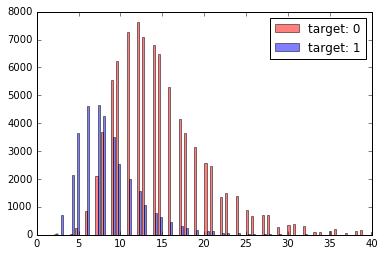

Histogram for len_question
                     count       mean       std  min  median   max
len_question (test)  74294  13.364834  6.123174  1.0    12.0  64.0


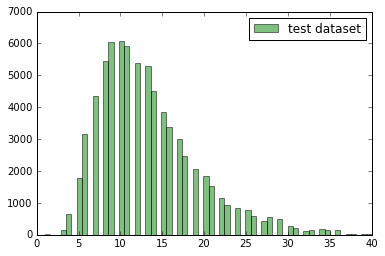

In [6]:
PlotHistByTarget(trainf.len_question, 'len_question', 0, 40, trainf, 'train')
PlotHistByTarget(testf.len_question, 'len_question', 0, 40, testf, 'test')

Histogram for len_paragraph
                           count       mean        std   min  median    max
len_paragraph (target: 0)  85361  90.372336  26.608021  35.0    82.0  358.0
len_paragraph (target: 1)  34037  83.477950  26.130164  28.0    77.0  675.0


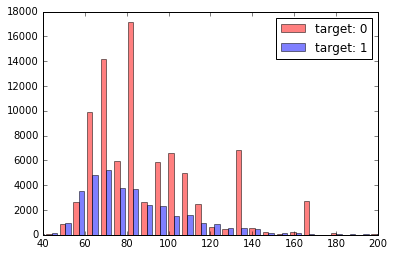

Histogram for len_paragraph
                      count       mean        std   min  median    max
len_paragraph (test)  74294  96.454667  40.660423  32.0    85.0  371.0


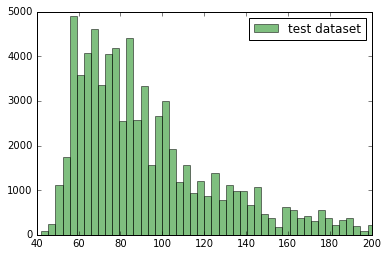

In [7]:
PlotHistByTarget(trainf.len_paragraph, 'len_paragraph', 40, 200, trainf, 'train')
PlotHistByTarget(testf.len_paragraph, 'len_paragraph', 40, 200, testf, 'test')

Histogram for len_intersection
                              count      mean       std  min  median   max
len_intersection (target: 0)  85361  3.339078  0.705591  3.0     3.0  17.0
len_intersection (target: 1)  34037  5.697006  4.117441  0.0     5.0  58.0


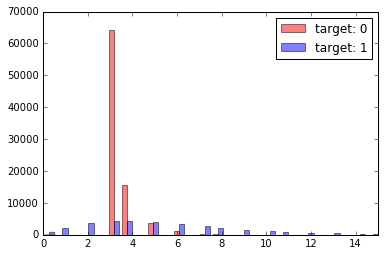

Histogram for len_intersection
                         count      mean       std  min  median   max
len_intersection (test)  74294  5.780171  3.354889  0.0     5.0  62.0


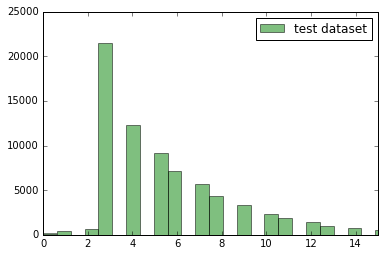

In [8]:
PlotHistByTarget(trainf.len_intersection, 'len_intersection', 0, 15, trainf, 'train')
PlotHistByTarget(testf.len_intersection, 'len_intersection', 0, 15, testf, 'test')

Histogram for min_ratio
                       count      mean       std  min   median      max
min_ratio (target: 0)  85361  0.110002  0.063889  0.0  0.12017  0.35345
min_ratio (target: 1)  34037  0.131520  0.068175  0.0  0.13506  0.97398


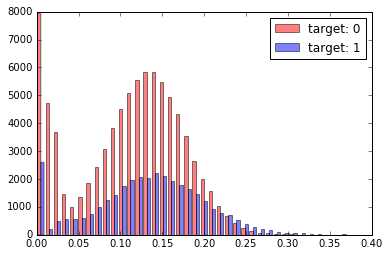

Histogram for min_ratio
                  count      mean       std  min  median      max
min_ratio (test)  74294  0.124086  0.073768  0.0  0.1327  0.98094


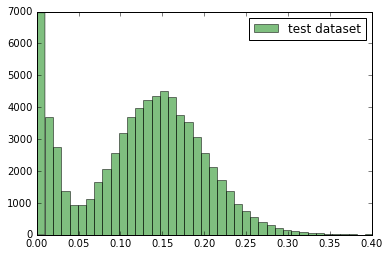

In [9]:
var_title = 'min_ratio' 
PlotHistByTarget(trainf.min_ratio, var_title, 0, 0.4, trainf, 'train')
PlotHistByTarget(testf.min_ratio, var_title, 0, 0.4, testf, 'test')

Histogram for max_ratio
                       count      mean       std      min  median      max
max_ratio (target: 0)  85361  0.269191  0.076324  0.00510  0.2766  0.83333
max_ratio (target: 1)  34037  0.429532  0.180929  0.02071  0.3871  0.99145


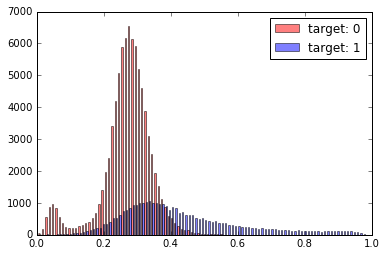

Histogram for max_ratio
                  count      mean      std  min   median      max
max_ratio (test)  74294  0.344035  0.13786  0.0  0.32787  0.99174


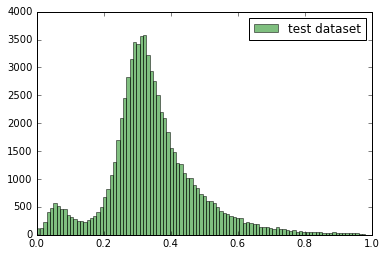

In [10]:
var_title = 'max_ratio' 
PlotHistByTarget(trainf.max_ratio, var_title, 0, 1, trainf, 'train')
PlotHistByTarget(testf.max_ratio, var_title, 0, 1, testf, 'test')

Histogram for std_ratio
                       count      mean       std  min    median       max
std_ratio (target: 0)  85361  0.055267  0.026044  0.0  0.053419  0.252462
std_ratio (target: 1)  34037  0.103941  0.063265  0.0  0.090241  0.450137


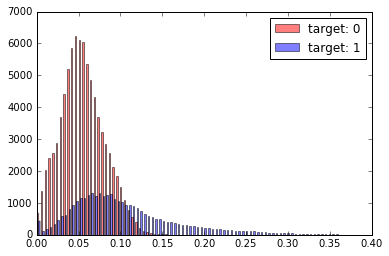

Histogram for std_ratio
                  count      mean       std  min    median       max
std_ratio (test)  74294  0.075219  0.044464  0.0  0.067267  0.434156


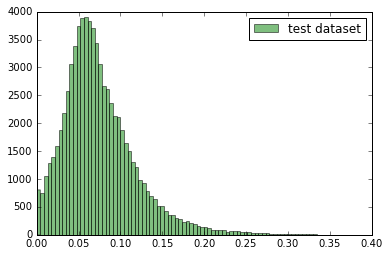

In [11]:
var_title = 'std_ratio' 
PlotHistByTarget(trainf.std_ratio, var_title, 0, 0.4, trainf, 'train')
PlotHistByTarget(testf.std_ratio, var_title, 0, 0.4, testf, 'test')

Histogram for mean_ratio
                        count      mean       std      min    median       max
mean_ratio (target: 0)  85361  0.191673  0.054721  0.00255  0.199163  0.429312
mean_ratio (target: 1)  34037  0.249552  0.069220  0.02071  0.245534  0.973980


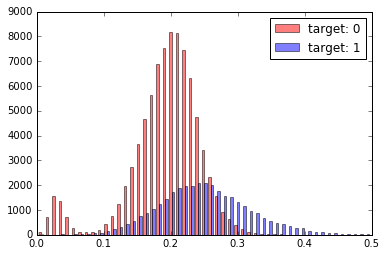

Histogram for mean_ratio
                   count     mean       std  min    median      max
mean_ratio (test)  74294  0.22189  0.075063  0.0  0.227771  0.98094


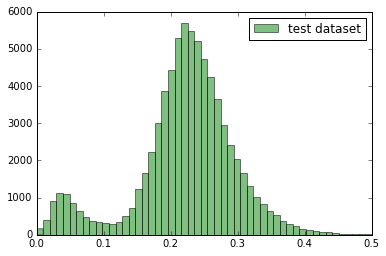

In [12]:
var_title = 'mean_ratio' 
PlotHistByTarget(trainf.mean_ratio, var_title, 0, 0.5, trainf, 'train')
PlotHistByTarget(testf.mean_ratio, var_title, 0, 0.5, testf, 'test')

Histogram for num_sentences
                           count      mean       std  min  median   max
num_sentences (target: 0)  85361  5.978608  2.415787  1.0     5.0  40.0
num_sentences (target: 1)  34037  5.745101  2.993409  1.0     5.0  73.0


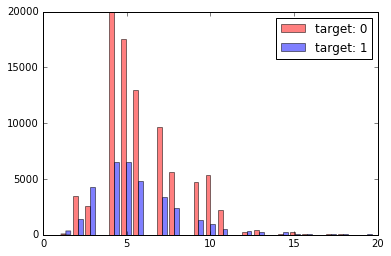

Histogram for num_sentences
                      count      mean       std  min  median   max
num_sentences (test)  74294  6.469728  3.482152  1.0     6.0  32.0


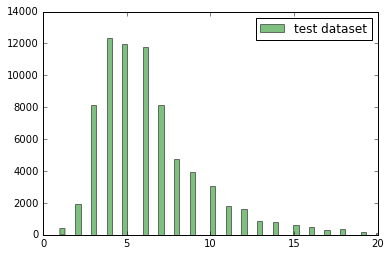

In [13]:
var_title = 'num_sentences' 
PlotHistByTarget(trainf.num_sentences, var_title, 0, 20, trainf, 'train')
PlotHistByTarget(testf.num_sentences, var_title, 0, 20, testf, 'test')

Histogram for min_inter
                       count      mean       std  min  median   max
min_inter (target: 0)  85361  0.226977  0.499684  0.0     0.0   7.0
min_inter (target: 1)  34037  0.253959  0.934635  0.0     0.0  53.0


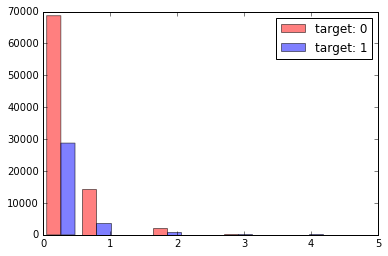

Histogram for min_inter
                  count      mean       std  min  median   max
min_inter (test)  74294  0.303403  0.877877  0.0     0.0  62.0


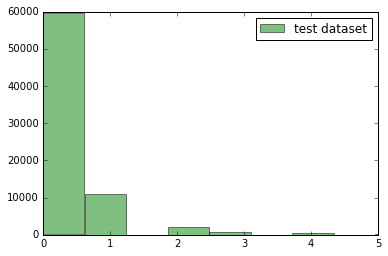

In [14]:
var_title = 'min_inter' 
PlotHistByTarget(trainf.min_inter, var_title, 0, 5, trainf, 'train')
PlotHistByTarget(testf.min_inter, var_title, 0, 5, testf, 'test')

Histogram for max_inter
                       count      mean       std  min  median   max
max_inter (target: 0)  85361  2.449163  0.767937  1.0     2.0  12.0
max_inter (target: 1)  34037  5.170256  3.970357  0.0     4.0  58.0


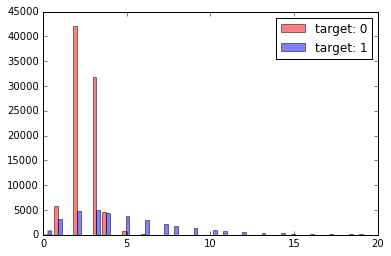

Histogram for max_inter
                  count      mean       std  min  median   max
max_inter (test)  74294  4.181697  2.648538  0.0     3.0  62.0


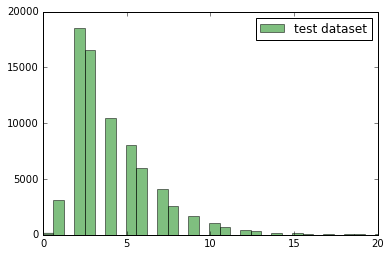

In [15]:
var_title = 'max_inter' 
PlotHistByTarget(trainf.max_inter, var_title, 0, 20, trainf, 'train')
PlotHistByTarget(testf.max_inter, var_title, 0, 20, testf, 'test')

Histogram for cos_dist
                      count      mean       std       min    median  max
cos_dist (target: 0)  85361  0.959705  0.070927  0.311293  0.987498  1.0
cos_dist (target: 1)  34037  0.653140  0.143093  0.008142  0.658757  1.0


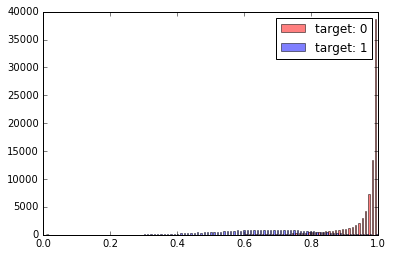

Histogram for cos_dist
                 count      mean       std      min    median  max
cos_dist (test)  74294  0.801063  0.145037  0.00975  0.830698  1.0


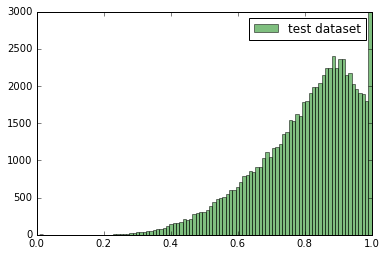

In [17]:
var_title = 'cos_dist' 
PlotHistByTarget(trainf.cos_dist, var_title, 0, 1, trainf, 'train')
PlotHistByTarget(testf.cos_dist, var_title, 0, 1, testf, 'test')

# Models

In [27]:
trainf.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'target',
       'list_ratio', 'list_intersections', 'len_paragraph', 'len_question',
       'len_intersection', 'cos_dist', 'min_ratio', 'max_ratio', 'std_ratio',
       'mean_ratio', 'num_sentences', 'min_inter', 'max_inter'],
      dtype='object')

In [7]:
columns = ['len_paragraph',
           'len_question',
           'len_intersection',
           'min_ratio',
           'max_ratio',
           'std_ratio',
           'mean_ratio',
           'num_sentences',
           'min_inter',
           'max_inter',
           'cos_dist'
          ]

## Gradient Boosting

In [277]:
model = GradientBoostingClassifier().fit(trainf[columns], trainf['target'])

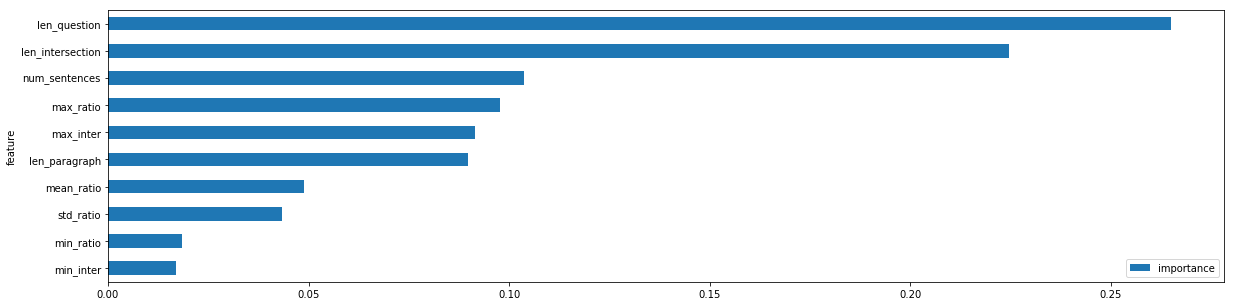

In [278]:
feat_importance(model, columns)

In [211]:
testf['prediction'] = model.predict(testf[columns])

In [212]:
testf.head()

,paragraph_id,question_id,paragraph,question,list_ratio,list_intersections,len_paragraph,len_question,len_intersection,min_ratio,max_ratio,std_ratio,mean_ratio,num_sentences,min_inter,max_inter,prediction
0,1361,6463,"Ïåðåäíèé ìîçã ñèëüíî ðàçâèò, ýòî ñàìàÿ áîëüøàÿ...",Â êàêîé ìèôîëîãèè äâà âîðîíà Õóãèí è Ìóíèí øåï...,"[0.25, 0.17964, 0.16162, 0.02597, 0.1641, 0.13...","[0, 0, 2, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 0]",113.0,14.0,3.0,0.00000,0.29834,0.090838,0.153921,14.0,0.0,3.0,0.0
1,1403,34696,Ìèðìåêîëîãè èññëåäóþò ìóðàâü¸â êàê â ëàáîðàòîð...,Êîãäà èíñàéäåð ïîêóïàåò èëè ãèïîòåçû ÷åãî ýâîë...,"[0.18265, 0.24409, 0.33696, 0.23077, 0.21017, ...","[0, 0, 5, 0, 0, 0]",79.0,11.0,5.0,0.18265,0.33696,0.048354,0.237508,6.0,0.0,5.0,1.0
2,1435,13751,Âîëíîâàÿ: ñâåò ïðåäñòàâëÿåò ñîáîé âîëíó â íåâè...,"Êàêèå ïðåäïîëîæåíèÿ, ïî ìíåíèþ Íüþòîíà, äîïóñò...","[0.23077, 0.17634, 0.33113]","[1, 3, 1]",63.0,12.0,3.0,0.17634,0.33113,0.064113,0.246080,3.0,1.0,3.0,0.0
3,341,38544,Æèâûå îðãàíèçìû ïîä÷èíÿþòñÿ íà÷àëàì òåðìîäèíàì...,Â êàêèõ óñëîâèÿõ ìåòàáîëèçì ïîääåðæèâàåò ïîðÿä...,"[0.32558, 0.29412, 0.17391, 0.27673, 0.33333, ...","[0, 0, 0, 1, 1, 9]",89.0,10.0,9.0,0.17391,0.89820,0.235975,0.383645,6.0,0.0,9.0,1.0
4,1317,14589,Ôàéëû íåëàòèíñêîãî òåêñòà â Þíèêîäå âñåãäà çàí...,Êàêèì ìåëîäèÿì Ïðîêîôüåâà îñîáåííî íå óêëàäûâà...,"[0.02812, 0.02824, 0.00893]","[8, 4, 4]",86.0,24.0,11.0,0.00893,0.02824,0.009075,0.021763,3.0,4.0,8.0,0.0


## Logistic Regression (unbalanced classes)

In [168]:
model_name = 'LogReg'

In [171]:
from sklearn.linear_model import LogisticRegression

balance_weight = 1.9029031375766812
lr = LogisticRegression(class_weight={0: 1, 1: balance_weight})
#
lr.fit(trainf[columns],trainf['target'])
testf['prediction'] = lr.predict(testf[columns])

In [ ]:
feat_importance(lr, columns)

In [172]:
print(testf[testf['prediction'] == 0].shape[0]/testf[testf['prediction'] == 1].shape[0])
balance_weight = testf[testf['prediction'] == 0].shape[0]/testf[testf['prediction'] == 1].shape[0]

1.5704598138601529


In [49]:
print('-'*10,'max_inter > 15.0', '-'*10)
testf[testf.max_inter > 15.0]['prediction'].value_counts()

---------- max_inter > 15.0 ----------


1.0    303
0.0     34
Name: prediction, dtype: int64

1.0    303
0.0     34
Name: prediction, dtype: int64

In [44]:
testf[testf.min_inter > 10.0]['prediction'].value_counts()

1.0    33
0.0    13
Name: prediction, dtype: int64

In [45]:
testf[testf.mean_ratio < 0.02]['prediction'].value_counts()

0.0    396
1.0    195
Name: prediction, dtype: int64

In [272]:
submit(testf['prediction'],model_name)

# XGBoost

In [48]:
columns = ['len_paragraph', 
           'len_question',
           'len_intersection',
           'min_ratio',
           'max_ratio',
           'std_ratio',
           'mean_ratio',
           'num_sentences',
           'min_inter',
           'max_inter',
           'cos_dist'
           ]

In [49]:
print(trainf[columns].shape, testf[columns].shape)

(119398, 11) (74294, 11)


In [110]:
import xgboost as xgb

params ={
        'eta':0.02,
        'n_estimators': 2000,
        'max_depth': 5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(trainf[columns], trainf['target'], test_size=0.2)

do_validation = True

if do_validation:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    dvalid = xgb.DMatrix(X_valid[columns], label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

dtest = xgb.DMatrix(testf[columns])
#preds = xgb_model.predict(dtest)

testf['prediction'] = xgb_model.predict(dtest,ntree_limit=xgb_model.best_iteration)

[0]	train-auc:0.98961	train(test)-auc:0.989126
Multiple eval metrics have been passed: 'train(test)-auc' will be used for early stopping.

Will train until train(test)-auc hasn't improved in 100 rounds.
[100]	train-auc:0.995621	train(test)-auc:0.995256
[200]	train-auc:0.996399	train(test)-auc:0.995955
[300]	train-auc:0.996779	train(test)-auc:0.996224
[400]	train-auc:0.997041	train(test)-auc:0.996429
[500]	train-auc:0.997231	train(test)-auc:0.99652
[600]	train-auc:0.997388	train(test)-auc:0.996576
[700]	train-auc:0.997525	train(test)-auc:0.996613
[800]	train-auc:0.99764	train(test)-auc:0.996643
[900]	train-auc:0.997759	train(test)-auc:0.996669
[1000]	train-auc:0.997859	train(test)-auc:0.996681
[1100]	train-auc:0.997961	train(test)-auc:0.996697
[1200]	train-auc:0.998048	train(test)-auc:0.996707
[1300]	train-auc:0.998137	train(test)-auc:0.996716
[1400]	train-auc:0.99821	train(test)-auc:0.996726
[1500]	train-auc:0.998303	train(test)-auc:0.99674
[1600]	train-auc:0.998387	train(test)-auc:0.9

In [129]:
#testf.head()

In [123]:
par = []
score = []
for k in xgb_model.get_fscore():
    par.append(k)
    score.append(xgb_model.get_fscore()[k])
res = pd.DataFrame({'variable':par,'split_counts':score})
res['importance'] = res['split_counts']/res['split_counts'].sum()
res.sort_values(by='importance',ascending=False)

,split_counts,variable,importance
7,5554,cos_dist,0.161458
0,4825,len_paragraph,0.140266
4,3792,mean_ratio,0.110236
2,3502,min_ratio,0.101805
8,3479,len_question,0.101137
5,3336,std_ratio,0.096980
10,2954,max_ratio,0.085875
9,2410,len_intersection,0.070060
3,2227,num_sentences,0.064740
6,1690,max_inter,0.049129


In [118]:
print(testf[testf['prediction'] < 0.5].shape[0]/testf[testf['prediction'] > 0.5].shape[0])

1.4464567966280295


In [116]:
submit(testf['prediction'],'XGB2000')

# Check

In [80]:
print('-'*10,'min_ratio > 0.4', '-'*10)
testf[testf.min_ratio>0.4]['prediction'].value_counts()

---------- min_ratio > 0.4 ----------


0.0    16
Name: prediction, dtype: int64

In [79]:
print('-'*10,'max_ratio > 0.9', '-'*10)
testf[testf.max_ratio > 0.9]['prediction'].value_counts()

---------- max_ratio > 0.9 ----------


0.0    231
Name: prediction, dtype: int64

In [43]:
print('-'*10,'max_ratio < 0.15', '-'*10)
testf[testf.max_ratio < 0.15]['prediction'].value_counts()

---------- max_ratio < 0.15 ----------


NameError: name 'testf' is not defined

In [83]:
print('-'*10,'std_ratio > 0.3', '-'*10)
testf[testf.std_ratio > 0.3]['prediction'].value_counts()

---------- std_ratio > 0.3 ----------


0.0    102
Name: prediction, dtype: int64

In [62]:
print('-'*10,'mean_ratio > 0.5', '-'*10)
testf[testf.mean_ratio > 0.5]['prediction'].value_counts()

---------- mean_ratio > 0.5 ----------


1.0    18
Name: prediction, dtype: int64

In [78]:
print('-'*10,'mean_ratio < 0.15', '-'*10)
testf[testf.mean_ratio < 0.15]['prediction'].value_counts()

---------- mean_ratio < 0.15 ----------


1.0    8814
0.0      86
Name: prediction, dtype: int64

In [77]:
print('-'*10,'min_inter > 10.0', '-'*10)
testf[testf.min_inter > 10.0]['prediction'].value_counts()

---------- min_inter > 10.0 ----------


0.0    46
Name: prediction, dtype: int64

In [76]:
print('-'*10,'max_inter > 15.0', '-'*10)
testf[testf.max_inter > 15.0]['prediction'].value_counts()

---------- max_inter > 15.0 ----------


0.0    337
Name: prediction, dtype: int64

In [69]:
#testf.loc[testf.min_ratio>0.4, 'prediction'] # = 1.0 # ok

In [70]:
#testf.loc[testf.max_ratio>0.9, 'prediction'] # = 1.0 # >0.85? ok

In [71]:
#testf.loc[testf.max_ratio<0.15, 'prediction'] # = 0.0 # ok

In [ ]:
#testf.loc[testf.std_ratio>0.3, 'prediction'] # = 1.0 # ok

In [ ]:
#testf.loc[testf.mean_ratio>0.5, 'prediction'] # = 1.0 # ok

In [ ]:
#testf.loc[testf.mean_ratio<0.15, 'prediction'] # = 0.0 # ok

In [ ]:
#test.loc[test.num_sentences>50, 'prediction'] = 1.0 # not available for test dataset

In [ ]:
#testf.loc[testf.min_inter>10, 'prediction'] # = 1.0 # ok

In [ ]:
#testf.loc[testf.max_inter>15, 'prediction'] # = 1.0 # ok

In [74]:
def SetTargetToTest(test):
    test.loc[test.min_ratio>0.4, 'prediction'] = float(int(1.0)^1) # ok
    test.loc[test.max_ratio>0.9, 'prediction'] = float(int(1.0)^1) # >0.85? ok
    test.loc[test.max_ratio<0.15, 'prediction'] = float(int(0.0)^1) # ok
    test.loc[test.std_ratio>0.3, 'prediction'] = float(int(1.0)^1) # ok
    test.loc[test.mean_ratio>0.5, 'prediction'] = float(int(1.0)^1) # ok
    test.loc[test.mean_ratio<0.15, 'prediction'] = float(int(0.0)^1) # ok
    #test.loc[test.num_sentences>50, 'prediction'] = 1.0)^1) # not available for test dataset
    test.loc[test.min_inter>10, 'prediction'] = float(int(1.0)^1) # ok
    test.loc[test.max_inter>15, 'prediction'] = float(int(1.0)^1) # ok

In [75]:
SetTargetToTest(testf)

In [173]:
submit(testf['prediction'],'LR_featset_cosdist')

# Feature Importance

In [98]:
def feat_importance(model, columns):
    features = pd.DataFrame()
    features['feature'] = columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    
    features.plot(kind='barh', figsize=(20, 5))
    plt.show()

# Submit

In [97]:
def submit_inv(preds,model_name):
    res_frame = pd.DataFrame({"paragraph_id": testf.paragraph_id,
              "question_id": testf.question_id,
              "prediction": list(map(lambda x: 1.0 if x==0.0 else 0.0, list(preds.values)))})
    res_frame[['paragraph_id','question_id','prediction']].to_csv("PD_"+model_name+".csv", index=False)

In [115]:
def submit(preds,model_name):
    res_frame = pd.DataFrame({"paragraph_id": testf.paragraph_id,
              "question_id": testf.question_id,
              "prediction": preds.values})
    res_frame[['paragraph_id','question_id','prediction']].to_csv("PD_"+model_name+".csv", index=False)